In [1]:
# consider doing K means over the partitions

In [2]:
import pandas, seaborn, os, numpy

import sklearn, sklearn.cluster
import scipy, scipy.stats

In [3]:
%matplotlib inline
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(9, 6), 'axes.labelsize':20})

# 0. user-defined variables

In [4]:
#! drangajokull
home_dir = '/home/adrian/'

#! necio5
#home_dir = '/Users/adrian/'

In [5]:
partial_wound_metabolic_file = '/home/adrian/gd15/hi/research/kerecis/data/clusters/df_logFC_comb_partial.csv'

In [6]:
days = [7, 14, 21, 28, 60]

# 1. read data

In [7]:
profiles = pandas.read_csv(partial_wound_metabolic_file, index_col=0)

print(profiles.shape)
profiles.head()

(318, 5)


,07,14,21,28,60
mz,,,,,
62.02452_pos,1.007395,1.237854,0.660272,0.474187,0.336748
71.02976_pos,0.697690,0.957674,0.366378,0.228073,0.003009
73.53242_pos,1.058873,1.265585,0.690517,0.497685,0.337213
76.04001_pos,1.625106,1.761488,1.705355,1.212304,0.492153
78.99967_pos,0.644034,1.071242,0.279089,0.282917,0.138536


In [8]:
zscore_profiles = pandas.DataFrame(scipy.stats.zscore(profiles, axis=1), index=profiles.index)

print(zscore_profiles.shape)
zscore_profiles.head()

(318, 5)


,07,14,21,28,60
mz,,,,,
62.02452_pos,0.789916,1.479203,-0.248305,-0.804872,-1.215942
71.02976_pos,0.728653,1.495218,-0.248226,-0.656020,-1.319625
73.53242_pos,0.836190,1.434499,-0.229984,-0.788117,-1.252588
76.04001_pos,0.560230,0.847658,0.729356,-0.309756,-1.827487
78.99967_pos,0.475527,1.738343,-0.603238,-0.591923,-1.018710


In [9]:
print(zscore_profiles.iloc[2, :])
print(numpy.mean(zscore_profiles.iloc[2, :]))
print(numpy.std(zscore_profiles.iloc[2, :]))

07    0.836190
14    1.434499
21   -0.229984
28   -0.788117
60   -1.252588
Name: 73.53242_pos, dtype: float64
8.881784197001253e-17
1.0


# 2. visualization and formatting

In [10]:
print(zscore_profiles.max())
print(zscore_profiles.min())

07    1.933265
14    1.934425
21    1.326718
28    1.369158
60    1.859738
dtype: float64
07   -1.969521
14   -0.599830
21   -1.193971
28   -1.068582
60   -1.942398
dtype: float64


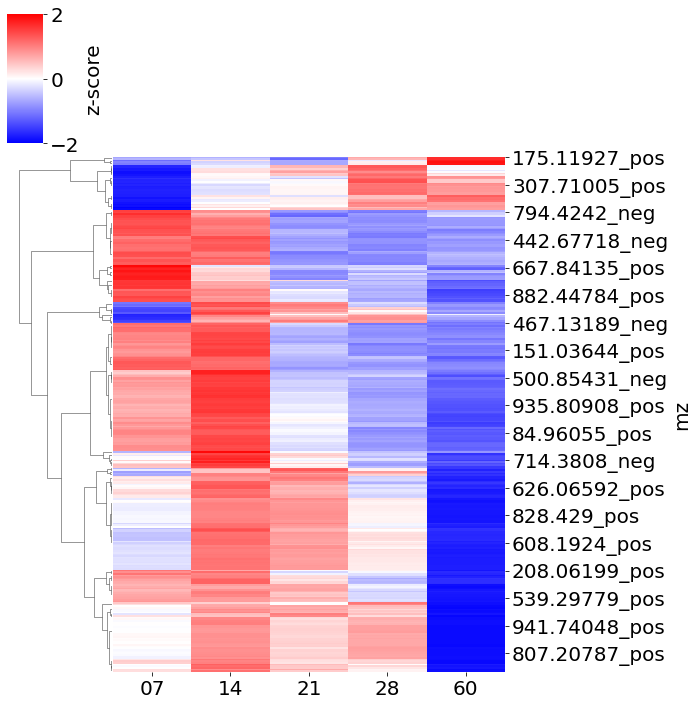

In [11]:
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.clustermap(zscore_profiles, cmap='bwr', vmin=-2, vmax=2, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'z-score'})

In [12]:
x = zscore_profiles.to_numpy()
x

array([[ 0.78991569,  1.47920349, -0.24830472, -0.80487198, -1.21594248],
       [ 0.72865347,  1.49521775, -0.24822649, -0.65602003, -1.31962469],
       [ 0.83619049,  1.43449878, -0.22998377, -0.78811722, -1.25258829],
       ...,
       [ 1.49758667,  0.75753821, -1.19397063, -0.84265083, -0.21850342],
       [ 1.2872932 ,  1.15456587, -0.69353067, -0.85768738, -0.89064102],
       [ 1.39604203,  1.00812373, -1.05223347, -0.75872323, -0.59320906]])

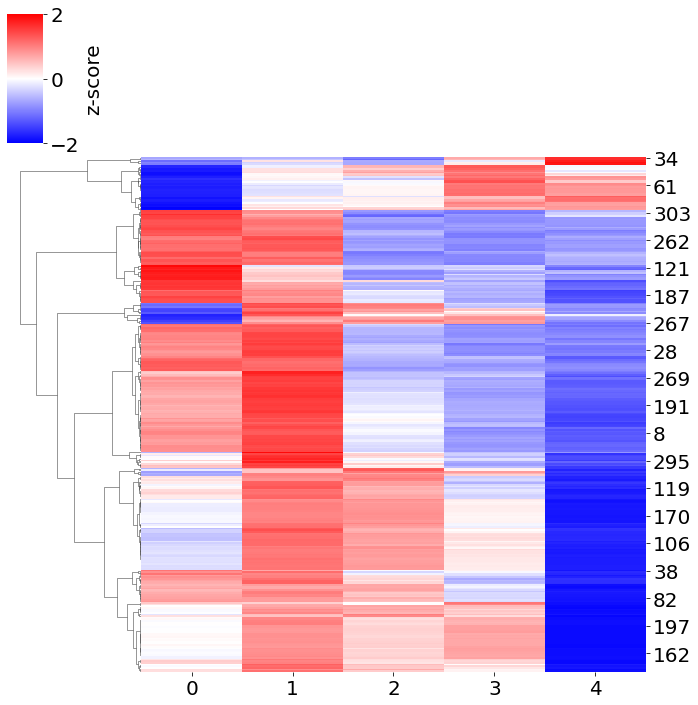

In [13]:
seaborn.clustermap(x, cmap='bwr', vmin=-2, vmax=2, col_cluster=False, method=linkage_method, metric=distance_metric,  cbar_kws={'label':'z-score'})

# 3. analysis

In [14]:
number_elements = zscore_profiles.shape[0]
print('number of elements {}'.format(number_elements))
fine = int(number_elements/5)
coarse = int(number_elements/20)
print(coarse, fine)
k_range = range(coarse, fine+1)

k_range = range(2, 15)

number of elements 318
15 63


In [15]:
p_ss = []; p_khi = []; p_dbi = []; all_labels = []

for k in k_range:

    partition = sklearn.cluster.AgglomerativeClustering(n_clusters=k, affinity='cosine', linkage='complete').fit(x)
    labels = partition.labels_

    ss = sklearn.metrics.silhouette_score(x, labels, metric='cosine')
    khi = sklearn.metrics.calinski_harabasz_score(x, labels)
    dbi = sklearn.metrics.davies_bouldin_score(x, labels)

    print(k, ss, khi, dbi)
    
    p_ss.append(ss)
    p_khi.append(khi)
    p_dbi.append(dbi)
    all_labels.append(labels)
    
    for clusterID in range(k):
        indices = numpy.where(labels == clusterID)[0]
        print('\t {} n = {}'.format(clusterID, len(indices)))        
        
    # 
    # plot trajectories
    #
    if k == 6:
        the_colors = ['plum', 'thistle', 'turquoise', 'magenta', 'tab:orange', 'gold']
        for clusterID in range(k):
            indices = numpy.where(labels == clusterID)[0]
            print('\nCluster c{} with {} gene indices: {}\n'.format(clusterID, len(indices), indices))
            cluster = zscore_profiles.iloc[indices, :]
            means = cluster.mean()
            stds = cluster.std()
            top = means + stds
            bottom = means - stds
        
            for metabolite in cluster.index:
                matplotlib.pyplot.plot(days, cluster.loc[metabolite, :], '.', alpha=1/3, lw=3, color=the_colors[clusterID])
            matplotlib.pyplot.plot(days, means, 'o-', color=the_colors[clusterID], lw=4, ms=20)
            matplotlib.pyplot.fill_between(days, top, bottom, color=the_colors[clusterID], alpha=0.2, lw=0)
            
            matplotlib.pyplot.xlabel('Time (day)')
            matplotlib.pyplot.ylabel('z-score')
            matplotlib.pyplot.grid(alpha=0.5, ls=':')
            matplotlib.pyplot.ylim([-2, 2])
            matplotlib.pyplot.title('k = {} | c{} | n = {}'.format(k, clusterID, len(indices)))
            matplotlib.pyplot.tight_layout()
            
            #matplotlib.pyplot.show()
            matplotlib.pyplot.savefig('{}.partial.svg'.format(the_colors[clusterID]))
            matplotlib.pyplot.clf()

2 0.7714169157288052 244.72066717553236 0.5483949657819807
	 0 n = 285
	 1 n = 33
3 0.40129062608742083 241.9577029273561 0.7849047780438466
	 0 n = 228
	 1 n = 33
	 2 n = 57
4 0.35158736376769634 212.7563647385062 0.8133151677331442
	 0 n = 215
	 1 n = 33
	 2 n = 57
	 3 n = 13
5 0.5906177460649481 414.6411959951638 0.8078989292993484
	 0 n = 33
	 1 n = 126
	 2 n = 57
	 3 n = 13
	 4 n = 89
6 0.5990508509775473 385.30321306720225 0.7502809735821186
	 0 n = 126
	 1 n = 89
	 2 n = 57
	 3 n = 13
	 4 n = 28
	 5 n = 5

Cluster c0 with 126 gene indices: [  3  18  19  23  26  27  30  32  36  37  38  41  43  44  46  51  52  53
  54  55  57  59  62  65  69  70  71  79  82  88  94  99 100 101 102 103
 104 105 106 107 108 110 111 112 113 114 115 116 117 118 119 120 123 124
 125 126 127 128 129 130 131 140 141 144 145 146 147 148 149 150 151 152
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 189 192 193 194 195
 196 197 

<Figure size 648x432 with 0 Axes>

# 4. plotting

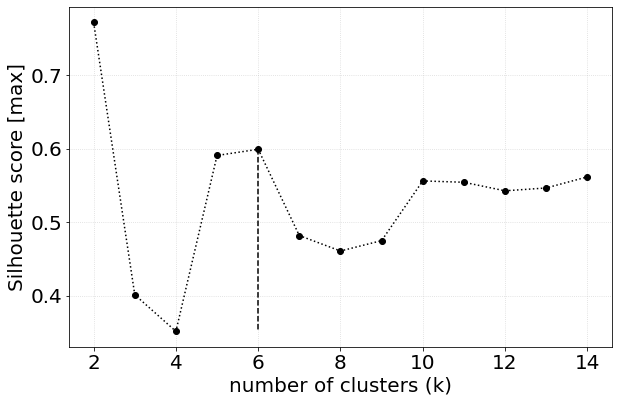

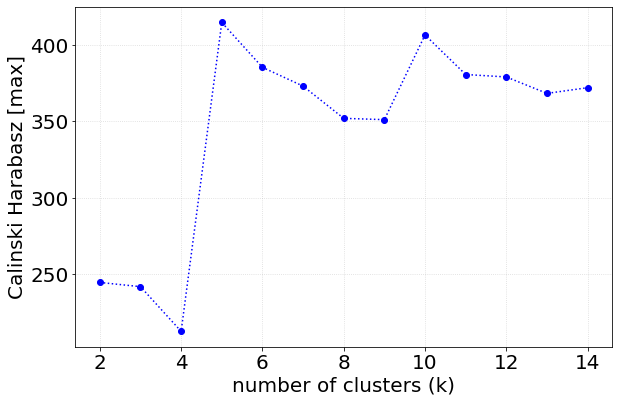

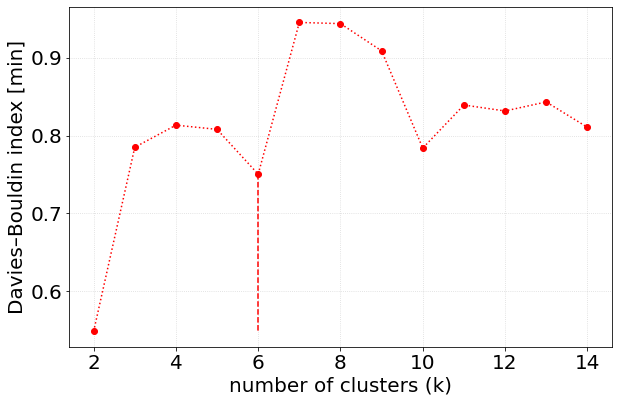

In [16]:
best_partition_index = 4 # which is cluster = 6

matplotlib.pyplot.plot(k_range, p_ss, 'ok')
matplotlib.pyplot.plot(k_range, p_ss, ':', color='black')

a = k_range[best_partition_index]
b = p_ss[best_partition_index]
c= numpy.min(p_ss)
matplotlib.pyplot.plot([a, a], [b, c], '--', color='black')

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Silhouette score [max]')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

matplotlib.pyplot.plot(k_range, p_khi, 'ob')
matplotlib.pyplot.plot(k_range, p_khi, ':', color='blue')
matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Calinski Harabasz [max]')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

matplotlib.pyplot.plot(k_range, p_dbi, 'or')
matplotlib.pyplot.plot(k_range, p_dbi, ':', color='red')

a = k_range[best_partition_index]
b = p_dbi[best_partition_index]
c= numpy.min(p_dbi)
matplotlib.pyplot.plot([a, a], [b, c], '--', color='red')

matplotlib.pyplot.grid(alpha=0.5, ls=':')
matplotlib.pyplot.xlabel('number of clusters (k)')
matplotlib.pyplot.ylabel('Davies–Bouldin index [min]')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

## 4.1. heatmap

In [17]:
groupings = all_labels[best_partition_index]
groupings

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 4, 5, 5, 1, 1, 3, 4, 0, 0, 3, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 5, 5, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 3, 0, 1, 2, 2, 3, 0, 0, 0, 0, 0, 2, 0, 4, 0, 1, 4, 0, 4, 4, 0,
       1, 1, 1, 0, 0, 0, 4, 4, 4, 1, 4, 4, 4, 0, 4, 4, 0, 4, 2, 2, 2, 2,
       0, 4, 4, 4, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       4, 2, 2, 2, 1, 4, 4, 4, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 1, 4, 0, 1, 1, 2, 4, 0,
       1, 1, 1, 2, 2, 1, 1, 3, 0, 1, 1, 1, 1, 1, 4, 3, 3, 5, 2, 2, 1, 2,
       2, 2, 1, 1, 2, 1, 1, 3, 1, 1, 4, 2, 3, 2, 1, 1, 1, 3, 1, 1, 2, 1,
       1, 2, 0, 3, 2, 1, 1, 1, 0, 0, 3, 2, 2, 2, 2, 1, 1, 1, 0, 1, 3, 1,
       1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2,

In [18]:
color_options = ['plum', 'thistle', 'turquoise', 'magenta', 'tab:orange', 'gold']
print(len(color_options))

k_colors = []
for i in range(len(zscore_profiles.index)):
  k_colors.append(color_options[groupings[i]])

# generate the figure with metabolite names
linkage_method = 'complete'
distance_metric = 'cosine'

seaborn.set(font_scale=0.9)
seaborn.clustermap(zscore_profiles, cmap='bwr', col_cluster=False, method=linkage_method, metric=distance_metric, cbar_kws={'label':'log2FC'}, row_colors=k_colors,vmin=-2, vmax=2)

matplotlib.pyplot.title('{} {}'.format(linkage_method, distance_metric))
matplotlib.pyplot.tight_layout()

#matplotlib.pyplot.show()

matplotlib.pyplot.savefig('heatmap.partial.svg')
matplotlib.pyplot.clf()

6


<Figure size 720x720 with 0 Axes>